In [24]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from moviepy import ImageSequenceClip
import os

In [25]:
TARGET_SIZE = (224, 224)  # Desired frame size
FRAME_NUMBER = 48 # Number of frames to sample

In [26]:
vid = cv2.VideoCapture('D:\\Fall_Detection\\Dataset\\Fall\\Raw_Video\\20240912_101331.mp4')
ret, frame = vid.read()

In [27]:
def load_and_resize(vid_path) : 
    vid = cv2.VideoCapture(vid_path)
    frames = []

    while True: 
        ret, frame = vid.read()
        if not ret:
            break
        resized_frame = cv2.resize(frame, TARGET_SIZE)
        frames.append(resized_frame)
    vid.release()
    return frames

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


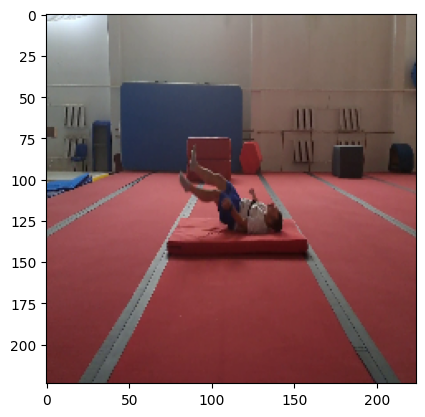

In [8]:
## rescaling the video frames
vid.set(cv2.CAP_PROP_POS_FRAMES, 0)  # Reset to the first frame
while True:
    ret, frame = vid.read()
    if not ret:
        break
    resized_frame = cv2.resize(frame, (224, 224))
    plt.imshow(cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB))
    print(resized_frame.shape)

In [31]:
def process_video(input_path, output_path, target_size=TARGET_SIZE, target_frames=64):
    cap = cv2.VideoCapture(input_path)
    frames = []

    # Read frames and resize
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, target_size)
        frames.append(frame)
    cap.release()

    # Pad if needed
    if len(frames) < target_frames:
        last_frame = frames[-1]
        frames.extend([last_frame] * (target_frames - len(frames)))

    # Trim if video is longer
    frames = frames[:target_frames]

    # Save as video
    clip = ImageSequenceClip([cv2.cvtColor(f, cv2.COLOR_BGR2RGB) for f in frames], fps=25)
    clip.write_videofile(output_path, codec="libx264")

    print(f"Saved processed video: {output_path}")


# Example
process_video("D:\\Fall_Detection\\Dataset\\Fall\\Raw_Video\\20240912_101331.mp4", "processed_224_48.mp4")

MoviePy - Building video processed_224_48.mp4.
MoviePy - Writing video processed_224_48.mp4



MoviePy - Done !
MoviePy - video ready processed_224_48.mp4
Saved processed video: processed_224_48.mp4


In [32]:
video_path = "processed_224_48.mp4"
cap = cv2.VideoCapture(video_path)

# Check input
ret, prev_frame = cap.read()
if not ret:
    print("ERROR: Cannot read first frame:", video_path)
    exit(1)

h, w = prev_frame.shape[:2]

# ---- Prepare background subtractor ----
bg = cv2.createBackgroundSubtractorMOG2(history=400, varThreshold=40, detectShadows=False)
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

# ---- Containers for saving ----
fg_masks = []        # list of foreground masks
flows = []           # list of optical flow arrays

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # ===== 1. Background Subtraction =====
    fgmask = bg.apply(frame)
    _, fgmask = cv2.threshold(fgmask, 250, 255, cv2.THRESH_BINARY)
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN,
                                cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15)))
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_CLOSE,
                                cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

    # ===== 2. Optical Flow =====
    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray,
                                        None,
                                        0.5, 3, 15, 3, 5, 1.2, 0)

    # Save for deep learning
    fg_masks.append(fgmask.astype(np.uint8))         # (H, W)
    flows.append(flow.astype(np.float32))            # (H, W, 2)

    prev_gray = gray

cap.release()

# ---- Save arrays ----
video_name = os.path.splitext(video_path)[0]
np.save(os.path.join( f"{video_name}_fg.npy"), np.array(fg_masks))
np.save(os.path.join( f"{video_name}_flow.npy"), np.array(flows))

print("Saved processed data for video:", video_path)

Saved processed data for video: processed_224_48.mp4
